## IMPORT LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import json
import warnings
warnings.filterwarnings('ignore')

## LOAD DATA

In [15]:
jobs_df = pd.read_csv('../processed/job_descriptions_parsed.csv')
cvs_df = pd.read_csv('../processed/cv_features_parsed.csv')
training_df = pd.read_csv('../processed/training_data.csv')

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nNumber of Job Descriptions: {len(jobs_df)}")
print(f"Number of CVs: {len(cvs_df)}")
print(f"Number of Training Pairs: {len(training_df)}")
print(f"\nAverage CVs per Job: {len(training_df) / len(jobs_df):.1f}")

DATASET OVERVIEW

Number of Job Descriptions: 853
Number of CVs: 2484
Number of Training Pairs: 42650

Average CVs per Job: 50.0


## FEATURE ENGINEERING FUNCTIONS

In [25]:
# Chuyển chuỗi JSON thành List
def parse_skills(skills_str):
    if pd.isna(skills_str) or not skills_str:
        return []
    try:
        return json.loads(skills_str)
    except:
        return []

# Tính chỉ số tương đồng (Jaccard) từ 2 skill sets (từ CV và JD)
def jaccard_similarity(set1, set2):
    if not set1 or not set2:
        return 0.0
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0.0

# Tính độ phủ (CV đáp ứng được bao nhiêu % nhu cầu về skills)
def skill_coverage(job_skills, cv_skills):
    if not job_skills:
        return 1.0
    if not cv_skills:
        return 0.0
    intersection = len(job_skills & cv_skills)
    return intersection / len(job_skills)

# Tính độ chính xác
def skill_precision(job_skills, cv_skills):
    if not cv_skills:
        return 0.0
    if not job_skills:
        return 0.0
    intersection = len(job_skills & cv_skills)
    return intersection / len(cv_skills)

# Tổng hợp các chỉ số về skills trên
def compute_skill_features(job_skills_str, cv_skills_str):
    job_skills = set(parse_skills(job_skills_str))
    cv_skills = set(parse_skills(cv_skills_str))
    
    return {
        'skill_jaccard': jaccard_similarity(job_skills, cv_skills),
        'skill_coverage': skill_coverage(job_skills, cv_skills),
        'skill_precision': skill_precision(job_skills, cv_skills),
        'skill_overlap_count': len(job_skills & cv_skills),
        'job_skills_count': len(job_skills),
        'cv_skills_count': len(cv_skills)
    }

# Tổng hợp các chỉ số về kinh nghiệm
def compute_experience_features(job_exp, cv_exp):
    if pd.isna(job_exp):
        job_exp = 0
    if pd.isna(cv_exp):
        cv_exp = 0
    
    exp_gap = cv_exp - job_exp
    exp_ratio = cv_exp / job_exp if job_exp > 0 else 0
    exp_match = 1 if exp_gap >= 0 else 0
    
    return {
        'experience_gap': exp_gap,
        'experience_ratio': exp_ratio,
        'experience_match': exp_match,
        'job_experience_required': job_exp,
        'cv_experience_years': cv_exp
    }

# Tổng hợp các chỉ số về trình độ học vấn
def compute_education_features(job_edu, cv_edu):
    edu_levels = {
        'high school': 0,
        'associate': 1,
        'undergraduate': 2,
        'bachelor': 3,
        'master': 4,
        'phd': 5
    }
    
    job_level = edu_levels.get(str(job_edu).lower(), 0) if pd.notna(job_edu) else 0
    cv_level = edu_levels.get(str(cv_edu).lower(), 0) if pd.notna(cv_edu) else 0
    
    edu_gap = cv_level - job_level
    edu_match = 1 if cv_level >= job_level else 0
    
    return {
        'education_gap': edu_gap,
        'education_match': edu_match,
        'job_education_level': job_level,
        'cv_education_level': cv_level
    }

# Tổng hợp các chỉ số về chức vụ
def compute_seniority_features(job_seniority, cv_exp):
    seniority_exp_map = {
        'intern': (0, 0),
        'junior': (0, 2),
        'mid': (2, 5),
        'senior': (5, 10),
        'manager': (8, 15),
        'executive': (12, 50)
    }
    
    if pd.isna(cv_exp):
        cv_exp = 0
    
    if pd.isna(job_seniority):
        return {'seniority_match_score': 0.5}
    
    min_exp, max_exp = seniority_exp_map.get(str(job_seniority).lower(), (0, 50))
    
    if min_exp <= cv_exp <= max_exp:
        score = 1.0
    elif cv_exp < min_exp:
        score = max(0, cv_exp / min_exp) if min_exp > 0 else 0
    else:
        score = max(0, 1 - (cv_exp - max_exp) / 10)
    
    return {'seniority_match_score': score}

print("Feature engineering functions defined")

Feature engineering functions defined


## MERGE DATA & GENERATE FEATURES

In [26]:
# Merge training data với job và CV features
print("Merging training data with job and CV features...")

merged_df = training_df.merge(
    jobs_df[['min_experience', 'education', 'seniority', 'skills']],
    left_on='job_id',
    right_index=True,
    how='left'
).merge(
    cvs_df[['experience_years', 'education', 'domain_skills']],
    left_on='cv_id',
    right_index=True,
    how='left',
    suffixes=('_job', '_cv')
)

print(f"Merged dataset shape: {merged_df.shape}")

# Tạo engineered features cho mỗi cặp CV và JD
print("\nGenerating engineered features...")
engineered_features = []

for idx, row in merged_df.iterrows():
    if (idx + 1) % 10000 == 0:
        print(f"  Processing {idx + 1}/{len(merged_df)}...")

    features = {
        'job_id': row['job_id'],
        'cv_id': row['cv_id'],
        'score': row['score']
    }

    # Skill features
    skill_feats = compute_skill_features(row['skills'], row['domain_skills'])
    features.update(skill_feats)

    # Experience features
    exp_feats = compute_experience_features(row['min_experience'], row['experience_years'])
    features.update(exp_feats)

    # Education features
    edu_feats = compute_education_features(row['education_job'], row['education_cv'])
    features.update(edu_feats)

    # Seniority features
    seniority_feats = compute_seniority_features(row['seniority'], row['experience_years'])
    features.update(seniority_feats)

    engineered_features.append(features)

engineered_df = pd.DataFrame(engineered_features)

print(f"\nEngineered features generated!")
print(f"  Shape: {engineered_df.shape}")
print(f"  Features: {[col for col in engineered_df.columns if col not in ['job_id', 'cv_id', 'score']]}")

Merging training data with job and CV features...
Merged dataset shape: (42650, 14)

Generating engineered features...
  Processing 10000/42650...
  Processing 20000/42650...
  Processing 30000/42650...
  Processing 40000/42650...

Engineered features generated!
  Shape: (42650, 19)
  Features: ['skill_jaccard', 'skill_coverage', 'skill_precision', 'skill_overlap_count', 'job_skills_count', 'cv_skills_count', 'experience_gap', 'experience_ratio', 'experience_match', 'job_experience_required', 'cv_experience_years', 'education_gap', 'education_match', 'job_education_level', 'cv_education_level', 'seniority_match_score']


## FEATURE STATISTICS

In [27]:
feature_cols = [col for col in engineered_df.columns if col not in ['job_id', 'cv_id', 'score']]

print("Feature Statistics:")
print(engineered_df[feature_cols].describe())

print("\nMissing Values:")
print(engineered_df[feature_cols].isnull().sum())

print("\nData Types:")
print(engineered_df[feature_cols].dtypes)

Feature Statistics:
       skill_jaccard  skill_coverage  skill_precision  skill_overlap_count  \
count   42650.000000    42650.000000     42650.000000         42650.000000   
mean        0.123131        0.226952         0.292522             1.221219   
std         0.103977        0.227413         0.257903             0.976401   
min         0.000000        0.000000         0.000000             0.000000   
25%         0.047619        0.090909         0.076923             1.000000   
50%         0.111111        0.181818         0.250000             1.000000   
75%         0.181818        0.300000         0.500000             2.000000   
max         1.000000        1.000000         1.000000            12.000000   

       job_skills_count  cv_skills_count  experience_gap  experience_ratio  \
count      42650.000000     42650.000000    42650.000000      42650.000000   
mean           6.643611         4.742438       -3.874631          0.722910   
std            3.698473         2.583373   

## FEATURE DISTRIBUTIONS

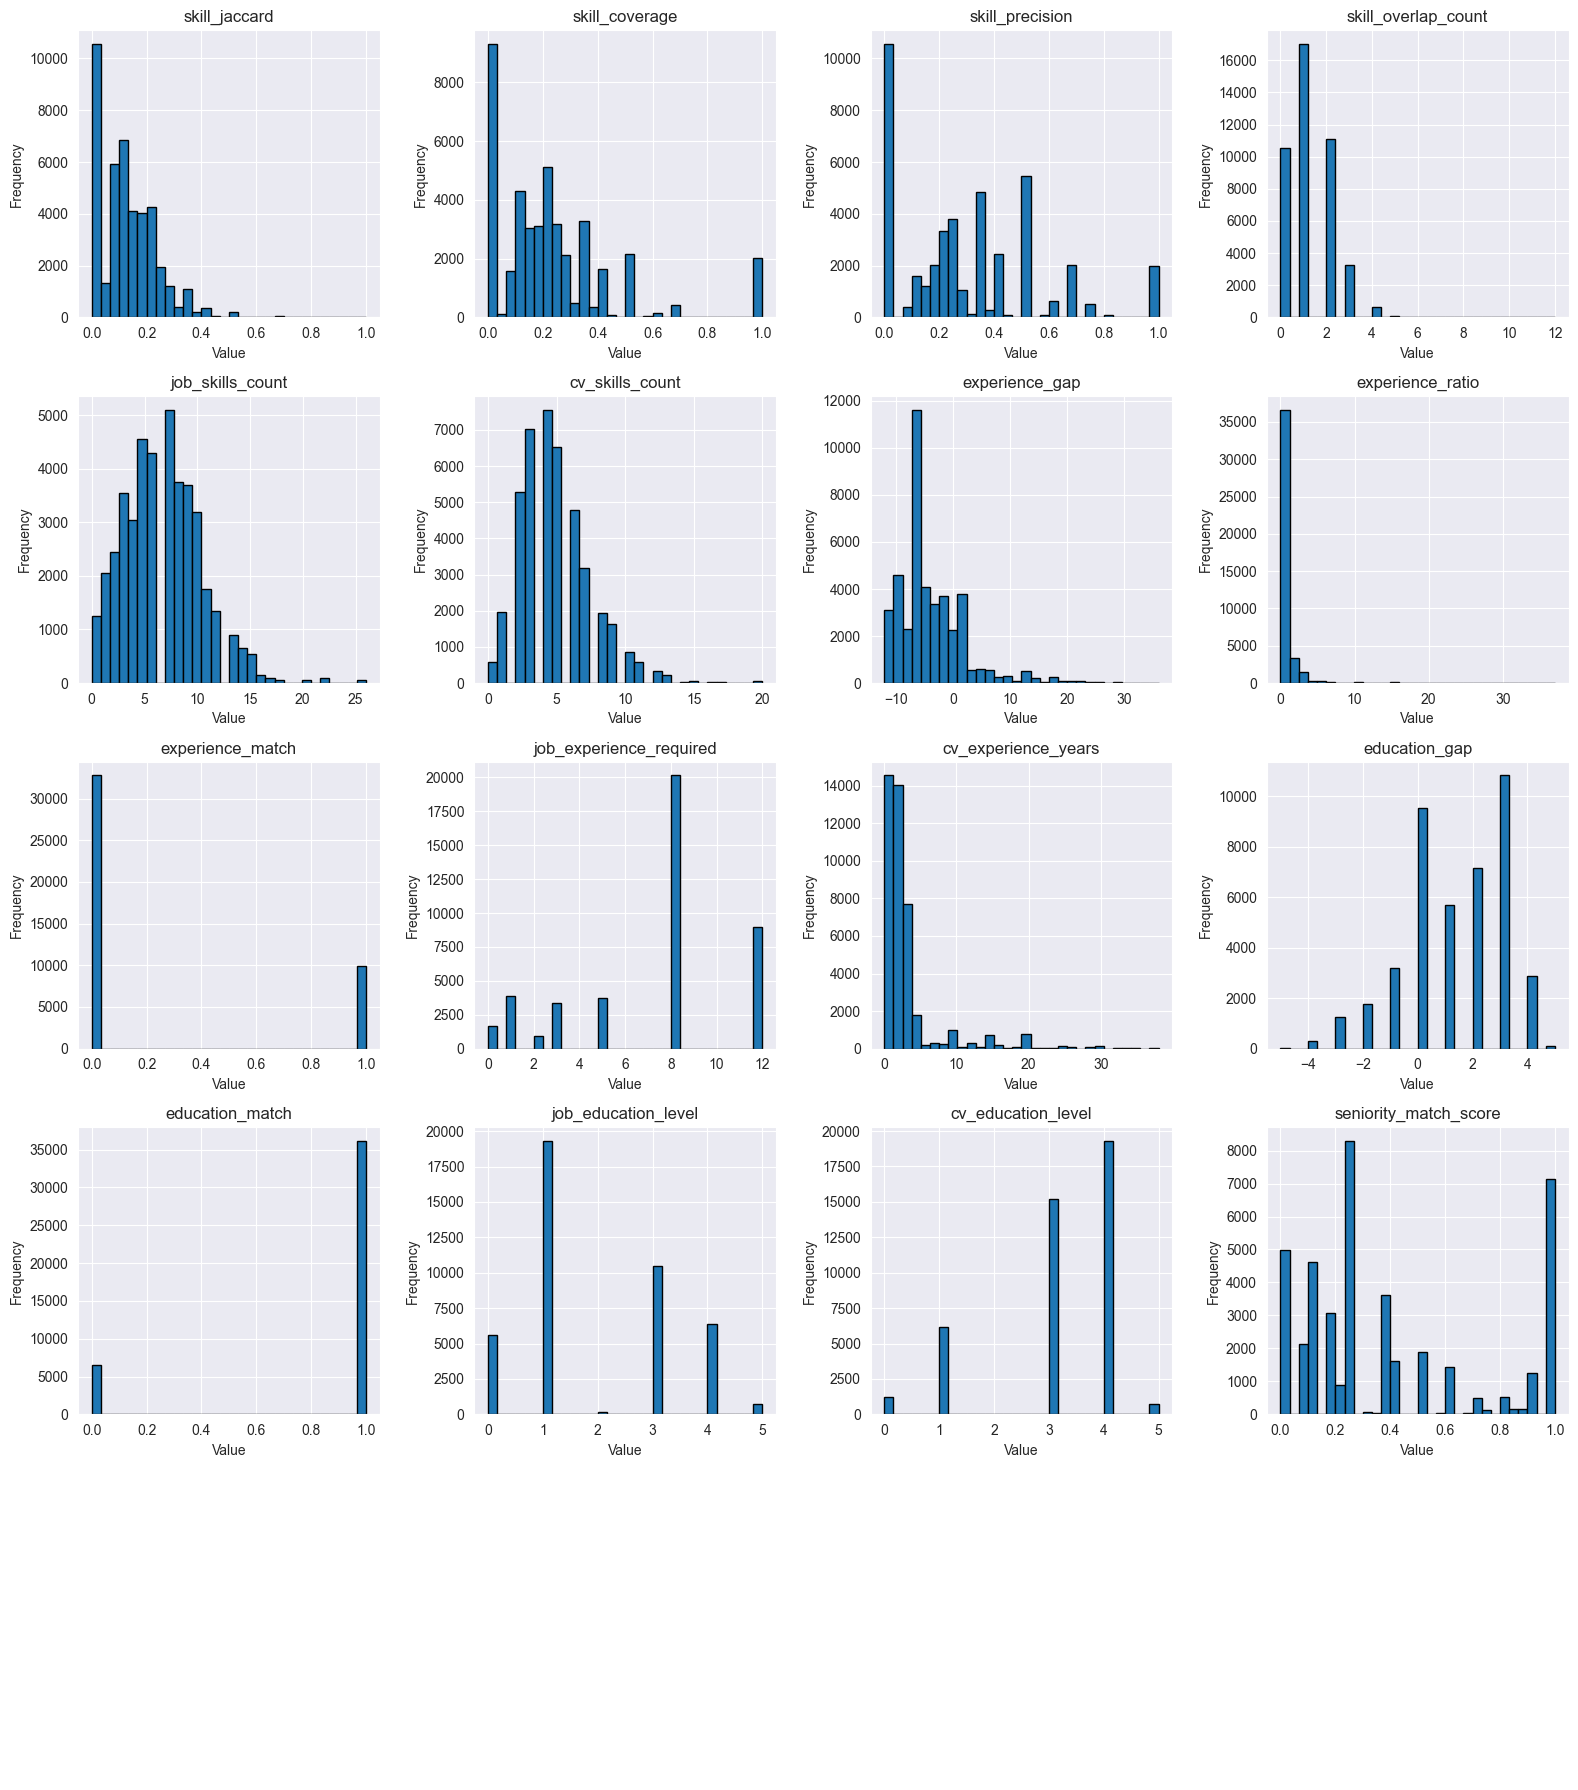

In [28]:
fig, axes = plt.subplots(5, 4, figsize=(16, 18))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    if idx < len(axes):
        axes[idx].hist(engineered_df[col], bins=30, edgecolor='black')
        axes[idx].set_title(f'{col}')
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Frequency')

for idx in range(len(feature_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## CORRELATION ANALYSIS

Computing correlations with target score...

Top 5 Features by Correlation with Score:
                       correlation
seniority_match_score     0.687015
experience_gap            0.663676
skill_coverage            0.563406
experience_match          0.516530
experience_ratio          0.505589

Bottom 5 Features by Correlation with Score:
                         correlation
cv_education_level          0.212826
skill_precision             0.132709
job_education_level        -0.312704
job_skills_count           -0.328147
job_experience_required    -0.576162


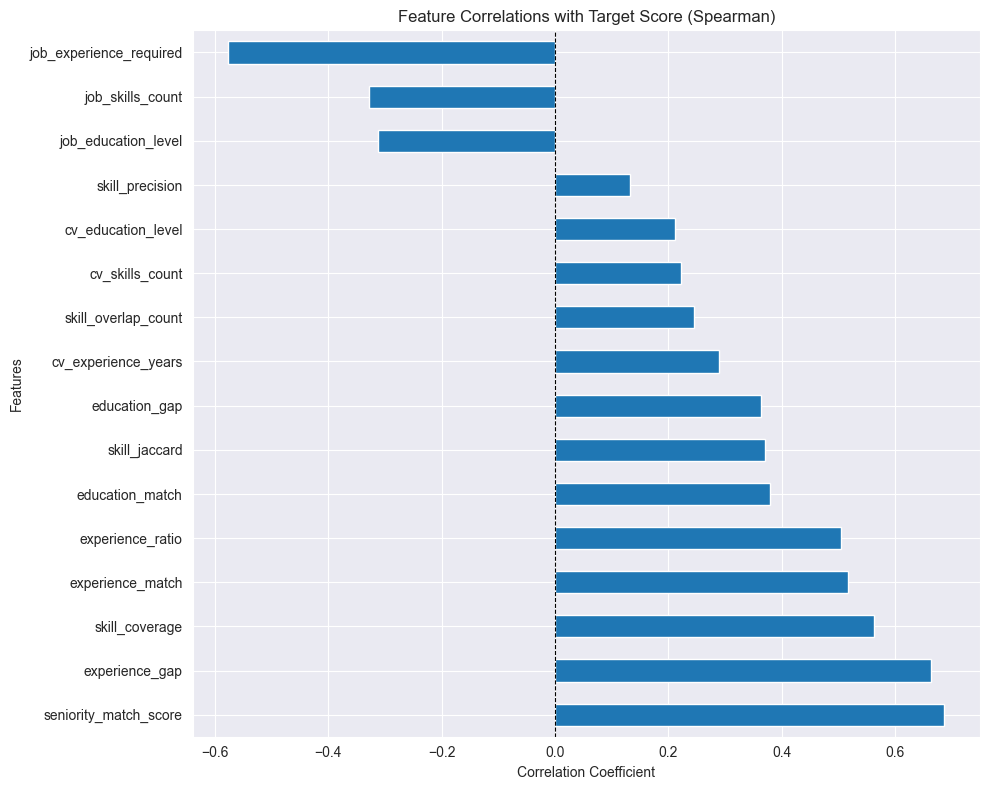

In [38]:
print("Computing correlations with target score...")
correlations = {}

for col in feature_cols:
    corr, p_value = spearmanr(engineered_df[col], engineered_df['score'])
    correlations[col] = corr

corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['correlation'])
corr_df = corr_df.sort_values('correlation', ascending=False)

print("\nTop 5 Features by Correlation with Score:")
print(corr_df.head(5))

print("\nBottom 5 Features by Correlation with Score:")
print(corr_df.tail(5))

corr_df.plot(
    kind='barh',
    figsize=(10, 8),
    legend=False
)

plt.title('Feature Correlations with Target Score (Spearman)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

## FEATURE CORRELATION MATRIX

Feature Correlation Matrix:
score                      1.000000
seniority_match_score      0.740526
skill_coverage             0.608890
experience_match           0.546364
experience_gap             0.469431
skill_jaccard              0.382446
education_gap              0.362056
education_match            0.342096
skill_overlap_count        0.198421
cv_education_level         0.188989
cv_skills_count            0.180361
experience_ratio           0.176478
cv_experience_years        0.119851
skill_precision            0.083759
job_education_level       -0.315377
job_skills_count          -0.343643
job_experience_required   -0.620572
Name: score, dtype: float64


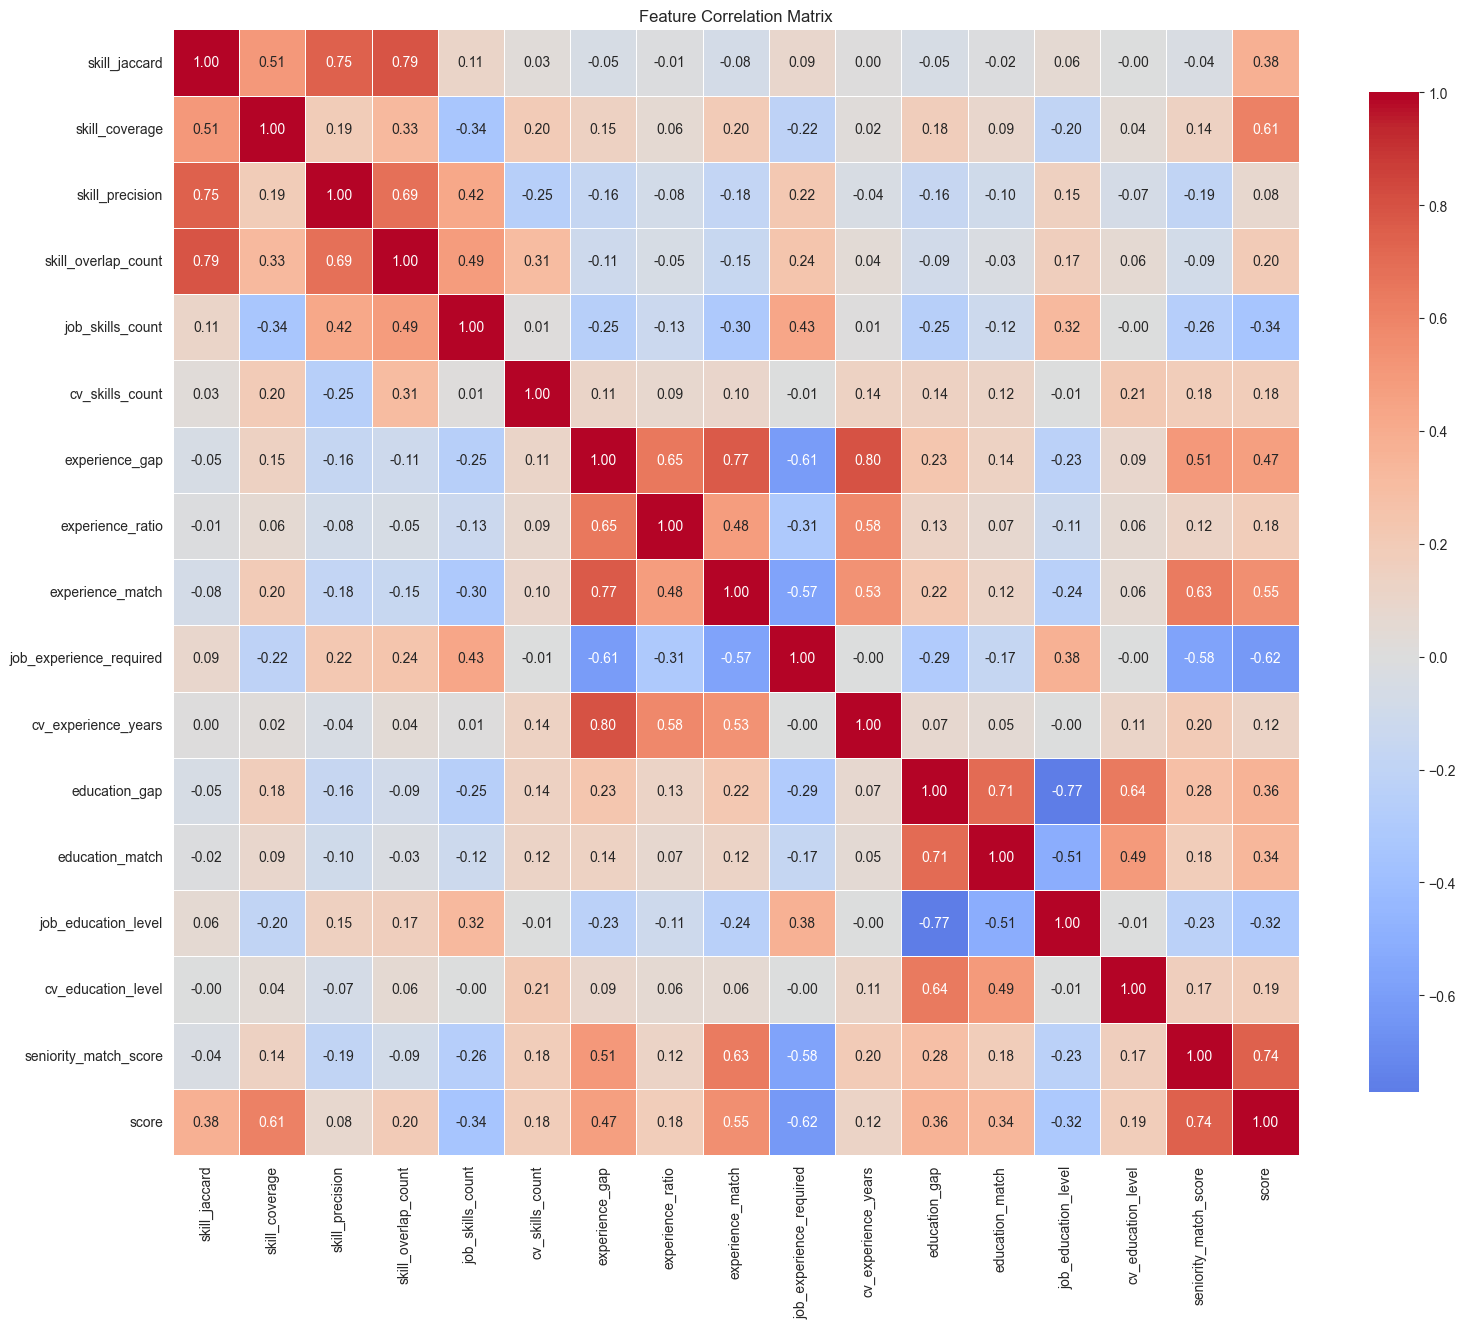


No severe multicollinearity detected


In [40]:
corr_matrix = engineered_df[feature_cols + ['score']].corr()

print("Feature Correlation Matrix:")
print(corr_matrix['score'].sort_values(ascending=False))

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'feature_1': corr_matrix.columns[i],
                'feature_2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print("\n⚠️  High multicollinearity detected (|r| > 0.8):")
    for pair in high_corr_pairs:
        print(f"  {pair['feature_1']} <-> {pair['feature_2']}: {pair['correlation']:.3f}")
else:
    print("\nNo severe multicollinearity detected")